# Introduction
The notebook implements an example described in [1].

# Prepare Quantum Oracle
The conversion of a classical circuit to a quantum circuit is still in its infancy. Consequently, we must manually convert Algorithm 3 to a format Qiskit understands.

The function Oracle (shown below) returns the result of the conversion to $f(x)$:

In [1]:
from qiskit.circuit import classical_function, Int1

@classical_function
def oracle(z1_bit1: Int1, z1_bit2: Int1, z2: Int1) -> Int1: # Int1 is Qiskit's bit type
    return (z1_bit1 and z1_bit2 and not z2) or \
           (z1_bit1 and not z1_bit2 and z2)

Once in this form, Qiskit’s `@classical_function` decorator automatically converts $f(x)$ to the quantum circuit (so called bit-flip oracle). Let's take a look at the circuit and associated OpenQASM code listing:

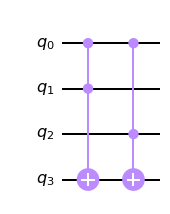

In [2]:
my_bitflip_oracle = oracle.synth()
my_bitflip_oracle.draw(output='mpl')

In [3]:
my_bitflip_oracle.qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
ccx q[0],q[1],q[3];
ccx q[0],q[2],q[3];



As described in the paper, the oracle's input is three bits long, i.e., $n = 3$. We will refer to it as `input_qubits_count` in this code listing:

In [4]:
input_qubits_count = 3

A phase-flip oracle is required to use Grover's algorithm. When bit-flip oracles are placed between NOT gates and Hadamard gates, they are converted to phase-flip oracles. To convert a bit-flip Oracle to a phase-flip Oracle, let's create a function named `get_phase_flip_oracle`:

In [5]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.classicalfunction import ClassicalFunction

def get_phase_flip_oracle(bitflip_oracle: ClassicalFunction, n: int) -> QuantumCircuit:
    """
    Convert a bit-flip oracle to a phase-flip oracle.

    :param bitflip_oracle: bit-flip oracle
    :param n: count of input qubits
    :return: phase-flip oracle
    """
    phase_oracle = QuantumCircuit(n+1)
    phase_oracle.x(n)
    phase_oracle.h(n)
    phase_oracle.compose(bitflip_oracle.synth(), inplace=True)
    phase_oracle.h(n)
    phase_oracle.x(n)
    return phase_oracle

Take a look at the circuit and OpenQASM code listing resulting from converting our bit-flip oracle to a phase-flip oracle:

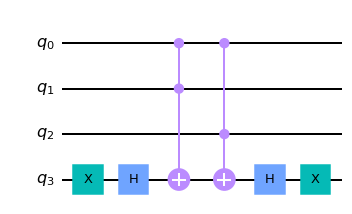

In [6]:
phase_flip_oracle = get_phase_flip_oracle(oracle, input_qubits_count)
phase_flip_oracle.draw(output='mpl')

In [7]:
phase_flip_oracle.qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
x q[3];
h q[3];
ccx q[0],q[1],q[3];
ccx q[0],q[2],q[3];
h q[3];
x q[3];



We will assume that we have passed our oracle to the quantum counting algorithm and obtained the number of inputs causing defects (denoted by $K$).

In [8]:
K = 2  # obtained from the quantum counting algorithm

As a result, we can calculate the number of Grover's iterations count $r(N, K)$, where $N = 2^n$ (see the paper for details):

In [9]:
from math import ceil, pi, sqrt, pow
r = ceil(pi / 4.0 * sqrt(pow(2, input_qubits_count) / K))
print(f"Grover's iterations count: {r}")

Grover's iterations count: 2


Grover's algorithm is readily available in Qiskit. First, we need to formulate the amplification problem and specify that we only need to measure the first three qubits (since we are not interested in the value returned by the oracle).

In [10]:
from qiskit.algorithms import AmplificationProblem

# create input to amplitude amplification algorithms (e.g., Grover's algorithm) and measure only the first three qubits
# as `list(range(input_qubits_count)) == list(range(3)) == [0, 1, 2]`
my_amplification_problem = AmplificationProblem(phase_flip_oracle, objective_qubits=list(range(input_qubits_count)))

# Identify specific inputs that cause failures
In this toy example, the values causing failures are `101` and `110`. Let's pass the amplification problem to Grover's algorithm and run it on three backends:

1. Qiskit simulator of an ideal quantum computer (QC),
2. Qiskit simulator of a real QC ibmq_lima, and
3. QC ibmq_lima.

Note that the outputs from all backends will vary from run to run.

## Simulator of an ideal quantum computer
Let's first execute the algorithm on a simulator of an ideal QC. By default, 1024 shots are taken.

In [11]:
from qiskit import Aer
from qiskit.algorithms import Grover

aer_simulator = Aer.get_backend('aer_simulator')
grover = Grover(quantum_instance=aer_simulator, iterations=r)
result = grover.amplify(my_amplification_problem)

Grover's algorithm returns the following distinct values:

In [12]:
print(result.circuit_results)

[{'011': 469, '111': 7, '000': 10, '010': 3, '001': 9, '100': 8, '110': 9, '101': 509}]


As Qiskit flips bit strings, the resulting bit strings can be reversed and converted to probability values as follows:

In [13]:
def reverse_labels(circuit_results: list) -> list:
    """
    Reverse labels in the "circuit results" data structure

    :param circuit_results: circuit results
    :return: the "circuit results" data structure with inverted labels
    """
    to_plot = {}
    labels = circuit_results[0].keys()
    for label in labels:
        to_plot[ label[::-1] ] = circuit_results[0][label]
    return [to_plot]

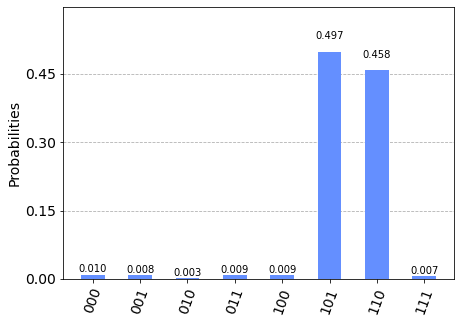

In [14]:
from qiskit.visualization import plot_histogram
plot_histogram(reverse_labels(result.circuit_results))

## Simulator of ibmq_lima
Let's try the search on a simulator of a real QC `ibmq_lima`. The default number of shots is 1024.


In [15]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import lima
aer_simulator = AerSimulator.from_backend(lima.FakeLima())
grover = Grover(quantum_instance=aer_simulator, iterations=r)
result = grover.amplify(my_amplification_problem)
print(result.circuit_results)

[{'011': 227, '111': 88, '001': 124, '100': 103, '110': 75, '010': 95, '000': 94, '101': 218}]


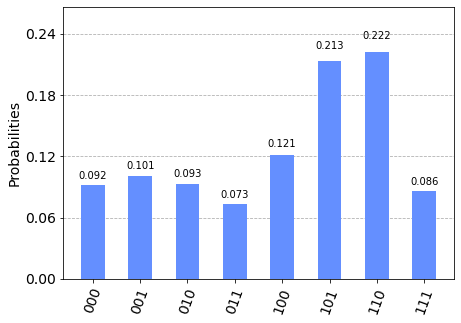

In [16]:
plot_histogram(reverse_labels(result.circuit_results))

## Actual ibmq_lima
Finally, let's use an actual QC `ibmq_lima`. By default, 4000 shots are taken. As your job will be queued, this step may take some time.

In [17]:
from qiskit import IBMQ

# Connect to your account. If you are running Qiskit code for the first time, uncomment the line below and
# add a secret token for your IBM Quantum account; see https://quantum-computing.ibm.com/ for details.

#IBMQ.save_account('YOUR TOKEN GOES HERE')
IBMQ.load_account() # Load account from disk

backend = IBMQ.get_provider(hub='ibm-q').get_backend('ibmq_lima')
grover = Grover(quantum_instance=backend, iterations=r)
result = grover.amplify(my_amplification_problem)
print(result.circuit_results)

[{'000': 369, '001': 570, '010': 499, '011': 605, '100': 403, '101': 605, '110': 457, '111': 492}]


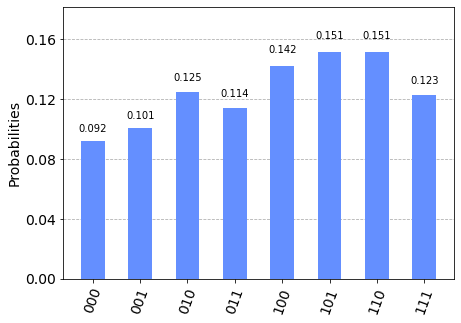

In [18]:
plot_histogram(reverse_labels(result.circuit_results))

# Summary
An ideal QC simulator gives the best results, while a real QC gives the worst.

# References
1. A. Miranskyy. 2022. Using Quantum Computers to Speed Up Dynamic Testing of Software. In Proceedings of the 1st International Workshop on Quantum Programming for Software Engineering (QP4SE ’22), November 18, 2022, Singapore, Singapore. ACM, New York, NY, USA, 6 pages. [https://doi.org/10.1145/3549036.3562061](https://doi.org/10.1145/3549036.3562061). To appear.

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table
